In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
# Importing Libraries
import os
import numpy as np
import pandas as pd

from PIL import Image
from glob import glob

from sklearn.preprocessing import LabelEncoder, StandardScaler

import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
import pydot

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, BatchNormalization, Dropout, Dense, MaxPool2D
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

from IPython.display import display

In [3]:
# Setting data directory
data_directory = os.path.join("/kaggle/input/", "skin-cancer-mnist-ham10000/")
os.listdir(data_directory)

['hmnist_8_8_RGB.csv',
 'hmnist_28_28_RGB.csv',
 'HAM10000_images_part_1',
 'ham10000_images_part_1',
 'hmnist_8_8_L.csv',
 'HAM10000_images_part_2',
 'ham10000_images_part_2',
 'hmnist_28_28_L.csv',
 'HAM10000_metadata.csv']

### Dataset Loading and Image Resizing
**Dataset Description**
<ol>
    <li>HAM10000_images_part_1: Contains 5000 dermatoscopic images
    <li>HAM10000_images_part_2: Contains 5015 dermatoscopic images
    <li>HAM10000_metadata.csv : Contains columns
    <ul>
        <li>lesion_id
        <li>image_id
        <li>dx: Diagnosis
        <li>dx_type: Diagnosis technique
        <li>age
        <li>sex
        <li>localisation: Body part
    </ul>
</ol>
Dataset is available at: https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/DBW86T

In [4]:
# Loading HAM10000_meatdata.csv 
data = pd.read_csv(os.path.join(data_directory, 'HAM10000_metadata.csv'))

In [5]:
data.sample(5)

,lesion_id,image_id,dx,dx_type,age,sex,localization
9184,HAM_0006105,ISIC_0032236,nv,histo,40.0,female,foot
7057,HAM_0006312,ISIC_0031337,nv,histo,60.0,female,foot
6990,HAM_0007579,ISIC_0027571,nv,histo,30.0,male,lower extremity
7020,HAM_0006605,ISIC_0027645,nv,histo,50.0,female,neck
7198,HAM_0005116,ISIC_0032953,nv,histo,5.0,female,lower extremity


In [6]:
# Creating dictionary for image path, and lesion type
# Adding images from both the folders
imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join(data_directory, '*', '*.jpg'))}

lesion_type_dict = {
    'nv': 'Melanocytic nevi (nv)',
    'mel': 'Melanoma (mel)',
    'bkl': 'Benign keratosis-like lesions (bkl)',
    'bcc': 'Basal cell carcinoma (bcc)',
    'akiec': 'Actinic keratoses (akiec)',
    'vasc': 'Vascular lesions (vasc)',
    'df': 'Dermatofibroma (df)'
}
label_mapping = {
    0: 'nv',
    1: 'mel',
    2: 'bkl',
    3: 'bcc',
    4: 'akiec',
    5: 'vasc',
    6: 'df'
}
reverse_label_mapping = dict((value, key) for key, value in label_mapping.items())

In [7]:
# Adding cell_type and image_path columns
data['cell_type'] = data['dx'].map(lesion_type_dict.get)
data['path'] = data['image_id'].map(imageid_path_dict.get)

In [8]:
%%time
# Adding image pixels
data['image_pixel'] = data['path'].map(lambda x: np.asarray(Image.open(x).resize((28,28))))

CPU times: user 1min 31s, sys: 1.77 s, total: 1min 33s
Wall time: 3min 20s


In [9]:
data.sample(5)

,lesion_id,image_id,dx,dx_type,age,sex,localization,cell_type,path,image_pixel
3469,HAM_0004826,ISIC_0027564,nv,follow_up,45.0,male,genital,Melanocytic nevi (nv),/kaggle/input/skin-cancer-mnist-ham10000/ham10...,"[[[230, 139, 151], [234, 142, 152], [243, 151,..."
8875,HAM_0006757,ISIC_0027271,nv,histo,55.0,male,lower extremity,Melanocytic nevi (nv),/kaggle/input/skin-cancer-mnist-ham10000/ham10...,"[[[218, 199, 189], [222, 205, 199], [222, 204,..."
7583,HAM_0003735,ISIC_0034149,nv,histo,40.0,female,back,Melanocytic nevi (nv),/kaggle/input/skin-cancer-mnist-ham10000/ham10...,"[[[173, 141, 166], [178, 147, 172], [180, 150,..."
4771,HAM_0004510,ISIC_0031110,nv,follow_up,60.0,male,back,Melanocytic nevi (nv),/kaggle/input/skin-cancer-mnist-ham10000/ham10...,"[[[230, 146, 154], [230, 147, 152], [232, 156,..."
2367,HAM_0006946,ISIC_0033349,vasc,histo,55.0,female,back,Vascular lesions (vasc),/kaggle/input/skin-cancer-mnist-ham10000/ham10...,"[[[184, 145, 150], [189, 150, 155], [188, 149,..."


## Exploratory Data Analysis

In [10]:
fig = make_subplots(rows=2, cols=2,
                    subplot_titles=['Sex', 'Localisation', 'Age', 'Skin Type'],
                    vertical_spacing=0.15,
                    column_widths=[0.4, 0.6])

fig.add_trace(go.Bar(
            x=data['sex'].value_counts().index, 
            y=data['sex'].value_counts()),
            row=1, col=1)
fig.add_trace(go.Bar(
            x=data['localization'].value_counts().index, 
            y=data['localization'].value_counts()),
            row=1, col=2)
fig.add_trace(go.Histogram(
            x=data['age']),
            row=2, col=1)
fig.add_trace(go.Bar(
            x=data['dx'].value_counts().index.map(lesion_type_dict.get), 
            y=data['dx'].value_counts()),
            row=2, col=2)

for i in range(4):
    fig.update_yaxes(title_text='Count', row=i//2+1, col=i%2+1)
fig.update_layout(title='Distribution of Data', height=800)

fig.show()

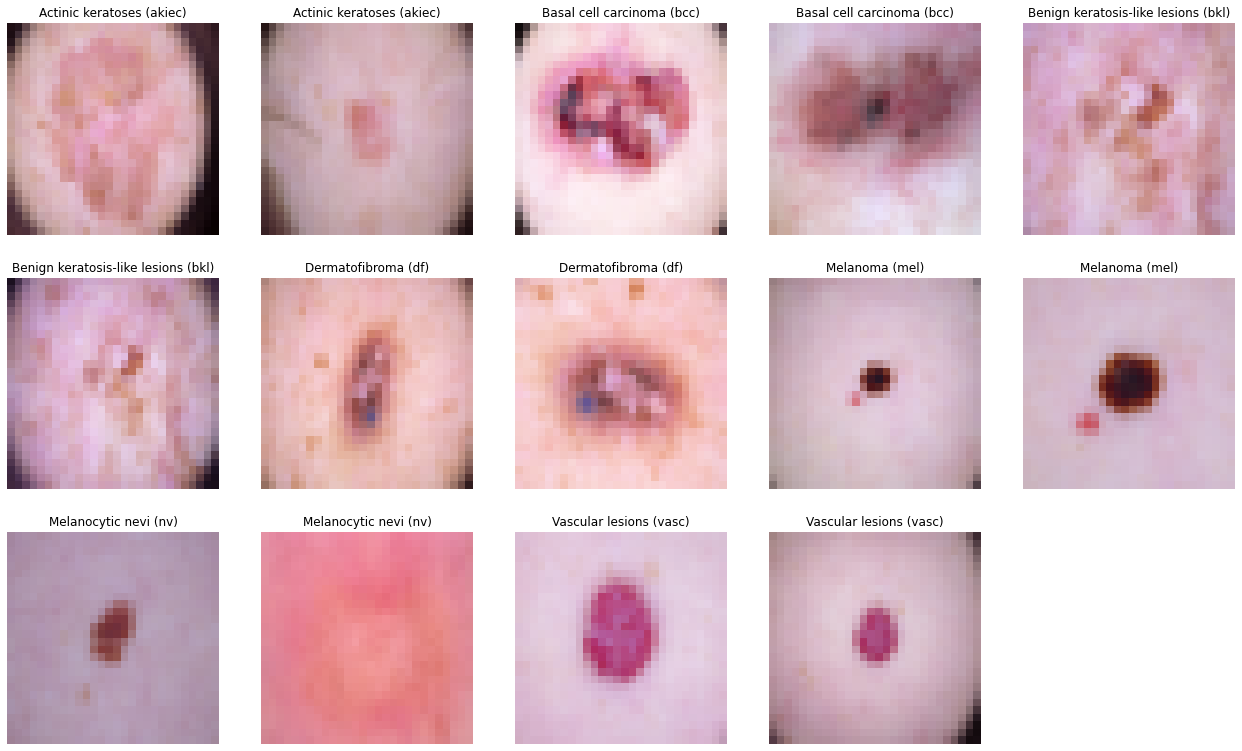

In [11]:
# Displaying 2 images for each label
sample_data = data.groupby('dx').apply(lambda df: df.iloc[:2, [9, 7]])
plt.figure(figsize=(22, 32))
for i in range(14):
    plt.subplot(7, 5, i + 1)
    plt.imshow(np.squeeze(sample_data['image_pixel'][i]))
    img_label = sample_data['cell_type'][i]
    plt.title(img_label)
    plt.axis("off")
plt.show()

## Preprocessing

In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10015 entries, 0 to 10014
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   lesion_id     10015 non-null  object 
 1   image_id      10015 non-null  object 
 2   dx            10015 non-null  object 
 3   dx_type       10015 non-null  object 
 4   age           9958 non-null   float64
 5   sex           10015 non-null  object 
 6   localization  10015 non-null  object 
 7   cell_type     10015 non-null  object 
 8   path          10015 non-null  object 
 9   image_pixel   10015 non-null  object 
dtypes: float64(1), object(9)
memory usage: 782.5+ KB


In [13]:
# Checking null values
data.isnull().sum()

lesion_id        0
image_id         0
dx               0
dx_type          0
age             57
sex              0
localization     0
cell_type        0
path             0
image_pixel      0
dtype: int64

In [14]:
# Handling null values
data['age'].fillna(value=int(data['age'].mean()), inplace=True)
# Converting dtype of age to int32
data['age'] = data['age'].astype('int32')

In [15]:
# Categorically encoding label of the images 
data['label'] = data['dx'].map(reverse_label_mapping.get)

In [16]:
data.sample(5)

,lesion_id,image_id,dx,dx_type,age,sex,localization,cell_type,path,image_pixel,label
4247,HAM_0006010,ISIC_0028695,nv,follow_up,75,female,back,Melanocytic nevi (nv),/kaggle/input/skin-cancer-mnist-ham10000/ham10...,"[[[213, 120, 120], [221, 131, 136], [225, 136,...",0
9792,HAM_0003157,ISIC_0029811,akiec,histo,65,male,upper extremity,Actinic keratoses (akiec),/kaggle/input/skin-cancer-mnist-ham10000/ham10...,"[[[200, 152, 165], [204, 161, 179], [206, 163,...",4
6962,HAM_0000230,ISIC_0032150,nv,histo,50,female,lower extremity,Melanocytic nevi (nv),/kaggle/input/skin-cancer-mnist-ham10000/ham10...,"[[[106, 95, 102], [126, 111, 121], [130, 118, ...",0
147,HAM_0003743,ISIC_0033646,bkl,histo,50,male,upper extremity,Benign keratosis-like lesions (bkl),/kaggle/input/skin-cancer-mnist-ham10000/ham10...,"[[[217, 200, 218], [220, 203, 220], [221, 208,...",2
9400,HAM_0006218,ISIC_0032589,nv,consensus,70,male,trunk,Melanocytic nevi (nv),/kaggle/input/skin-cancer-mnist-ham10000/ham10...,"[[[171, 154, 184], [177, 160, 189], [179, 160,...",0


## Data Augmentation

In [17]:
data = data.sort_values('label')
data = data.reset_index()

In [18]:
%%time
index1 = data[data['label'] == 1].index.values
index2 = data[data['label'] == 2].index.values
index3 = data[data['label'] == 3].index.values
index4 = data[data['label'] == 4].index.values
index5 = data[data['label'] == 5].index.values
index6 = data[data['label'] == 6].index.values

df_index1 = data.iloc[int(min(index1)):int(max(index1)+1)]
df_index2 = data.iloc[int(min(index2)):int(max(index2)+1)]
df_index3 = data.iloc[int(min(index3)):int(max(index3)+1)]
df_index4 = data.iloc[int(min(index4)):int(max(index4)+1)]
df_index5 = data.iloc[int(min(index5)):int(max(index5)+1)]
df_index6 = data.iloc[int(min(index6)):int(max(index6)+1)]

df_index1 = df_index1.append([df_index1]*4, ignore_index = True)
df_index2 = df_index2.append([df_index2]*4, ignore_index = True)
df_index3 = df_index3.append([df_index3]*11, ignore_index = True)
df_index4 = df_index4.append([df_index4]*17, ignore_index = True)
df_index5 = df_index5.append([df_index5]*45, ignore_index = True)
df_index6 = df_index6.append([df_index6]*52, ignore_index = True)

frames = [data, df_index1, df_index2, df_index3, df_index4, df_index5, df_index6]
final_data = pd.concat(frames)

CPU times: user 106 ms, sys: 5.96 ms, total: 112 ms
Wall time: 120 ms


In [19]:
%%time
print(data.shape)
print(final_data.shape)

(10015, 12)
(45756, 12)
CPU times: user 0 ns, sys: 174 µs, total: 174 µs
Wall time: 143 µs


In [20]:
fig = make_subplots(rows=2, cols=2,
                    subplot_titles=['Sex', 'Localisation', 'Age', 'Skin Type'],
                    vertical_spacing=0.15,
                    column_widths=[0.4, 0.6])

fig.add_trace(go.Bar(
            x=final_data['sex'].value_counts().index, 
            y=final_data['sex'].value_counts()),
            row=1, col=1)
fig.add_trace(go.Bar(
            x=final_data['localization'].value_counts().index, 
            y=final_data['localization'].value_counts()),
            row=1, col=2)
fig.add_trace(go.Histogram(
            x=final_data['age']),
            row=2, col=1)
fig.add_trace(go.Bar(
            x=final_data['dx'].value_counts().index.map(lesion_type_dict.get), 
            y=final_data['dx'].value_counts()),
            row=2, col=2)

for i in range(4):
    fig.update_yaxes(title_text='Count', row=i//2+1, col=i%2+1)
fig.update_layout(title='Distribution of Data after augmentation', height=800)

fig.show()

**Creating 2 sets of data for Model Training and Testing**
<p>Original Data: Without solving class imbalance problem
<p>Augmented Data: After solving class imbalance problem

In [21]:
# ORIGINAL DATA
# Converting image pixel columnm into required format
X_orig = data['image_pixel'].to_numpy()
X_orig = np.stack(X_orig, axis=0)
Y_orig = np.array(data.iloc[:, -1:])
print(X_orig.shape)
print(Y_orig.shape)

(10015, 28, 28, 3)
(10015, 1)


In [22]:
# AUGMENTED DATA
# Converting image pixel columnm into required format
X_aug = final_data['image_pixel'].to_numpy()
X_aug = np.stack(X_aug, axis=0)
Y_aug = np.array(final_data.iloc[:, -1:])
print(X_aug.shape)
print(Y_aug.shape)

(45756, 28, 28, 3)
(45756, 1)


## Functions for Model Creation, Training, and Testing

In [23]:
%%time
def prepare_for_train_test(X, Y):
    # Splitting into train and test set
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=1)
    
    # Prepare data for training and testing the model
    train_datagen = ImageDataGenerator(rescale = 1./255,
                                  rotation_range = 10,
                                  width_shift_range = 0.2,
                                  height_shift_range = 0.2,
                                  shear_range = 0.2,
                                  horizontal_flip = True,
                                  vertical_flip = True,
                                  fill_mode = 'nearest')
    train_datagen.fit(X_train)
    test_datagen = ImageDataGenerator(rescale = 1./255)
    test_datagen.fit(X_test)
    return X_train, X_test, Y_train, Y_test

def create_model():
    model = Sequential()
    model.add(Conv2D(16, kernel_size = (3,3), input_shape = (28, 28, 3), activation = 'relu', padding = 'same'))
    model.add(MaxPool2D(pool_size = (2,2)))

    model.add(Conv2D(32, kernel_size = (3,3), activation = 'relu', padding = 'same'))
    model.add(MaxPool2D(pool_size = (2,2), padding = 'same'))

    model.add(Conv2D(64, kernel_size = (3,3), activation = 'relu', padding = 'same'))
    model.add(MaxPool2D(pool_size = (2,2), padding = 'same'))
    model.add(Conv2D(128, kernel_size = (3,3), activation = 'relu', padding = 'same'))
    model.add(MaxPool2D(pool_size = (2,2), padding = 'same'))

    model.add(Flatten())
    model.add(Dense(64, activation = 'relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(7, activation='softmax'))

    optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001)

    model.compile(loss = 'sparse_categorical_crossentropy',
                 optimizer = optimizer,
                  metrics = ['accuracy'])
    print(model.summary())
#     tf.keras.utils.plot_model(model, to_file="model.png")
    return model;

def train_model(model, X_train, Y_train, EPOCHS=25):
    early_stop = EarlyStopping(monitor='val_loss', patience=10, verbose=1, 
                           mode='auto', restore_best_weights=True)
    
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, 
                              verbose=1, mode='auto')
    
    history = model.fit(X_train,
                        Y_train,
                        validation_split=0.2,
                        batch_size = 64,
                        epochs = EPOCHS,
                        callbacks = [reduce_lr, early_stop])
    return history
    
def plot_model_training_curve(history):
    fig = make_subplots(rows=1, cols=2, subplot_titles=['Model Accuracy', 'Model Loss'])
    fig.add_trace(
        go.Scatter(
            y=history.history['accuracy'], 
            name='train_acc'), 
        row=1, col=1)
    fig.add_trace(
        go.Scatter(
            y=history.history['val_accuracy'], 
            name='val_acc'), 
        row=1, col=1)
    fig.add_trace(
        go.Scatter(
            y=history.history['loss'], 
            name='train_loss'), 
        row=1, col=2)
    fig.add_trace(
        go.Scatter(
            y=history.history['val_loss'], 
            name='val_loss'), 
        row=1, col=2)
    fig.show()
    
def test_model(model, X_test, Y_test):
    model_acc = model.evaluate(X_test, Y_test, verbose=0)[1]
    print("Test Accuracy: {:.3f}%".format(model_acc * 100))
    y_true = np.array(Y_test)
    y_pred = model.predict(X_test)
    y_pred = np.array(list(map(lambda x: np.argmax(x), y_pred)))
    clr = classification_report(y_true, y_pred, target_names=label_mapping.values())
    print(clr)
    
    sample_data = X_test[:15]
    plt.figure(figsize=(22, 12))
    for i in range(15):
        plt.subplot(3, 5, i + 1)
        plt.imshow(sample_data[i])
        plt.title(label_mapping[y_true[i][0]] + '|' + label_mapping[y_pred[i]])
        plt.axis("off")
    plt.show() 

CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 9.06 µs


In [24]:
# For Original Dataset
X_train_orig, X_test_orig, Y_train_orig, Y_test_orig = prepare_for_train_test(X_orig, Y_orig)

In [25]:
model1 = create_model()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 16)        448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 64)          18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 4, 64)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 4, 4, 128)         7

In [26]:
model1_history = train_model(model1, X_train_orig, Y_train_orig, 50)

Epoch 1/50
101/101 [==============================] - 4s 10ms/step - loss: 5.2047 - accuracy: 0.5773 - val_loss: 0.9722 - val_accuracy: 0.6550
Epoch 2/50
101/101 [==============================] - 0s 4ms/step - loss: 0.9811 - accuracy: 0.6708 - val_loss: 0.9321 - val_accuracy: 0.6638
Epoch 3/50
101/101 [==============================] - 0s 4ms/step - loss: 0.9100 - accuracy: 0.6777 - val_loss: 0.8666 - val_accuracy: 0.6812
Epoch 4/50
101/101 [==============================] - 0s 4ms/step - loss: 0.8487 - accuracy: 0.6947 - val_loss: 0.8220 - val_accuracy: 0.6881
Epoch 5/50
101/101 [==============================] - 0s 4ms/step - loss: 0.8008 - accuracy: 0.7092 - val_loss: 0.8464 - val_accuracy: 0.6756
Epoch 6/50
101/101 [==============================] - 0s 4ms/step - loss: 0.7919 - accuracy: 0.7088 - val_loss: 0.8212 - val_accuracy: 0.6949
Epoch 7/50
101/101 [==============================] - 0s 4ms/step - loss: 0.7715 - accuracy: 0.7142 - val_loss: 0.8313 - val_accuracy: 0.6875
Epoch

In [27]:
plot_model_training_curve(model1_history)

Test Accuracy: 77.034%
              precision    recall  f1-score   support

          nv       0.85      0.94      0.89      1374
         mel       0.52      0.34      0.41       205
         bkl       0.58      0.37      0.46       227
         bcc       0.44      0.64      0.52        94
       akiec       0.43      0.33      0.37        55
        vasc       0.68      0.61      0.64        28
          df       0.00      0.00      0.00        20

    accuracy                           0.77      2003
   macro avg       0.50      0.46      0.47      2003
weighted avg       0.75      0.77      0.75      2003



/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



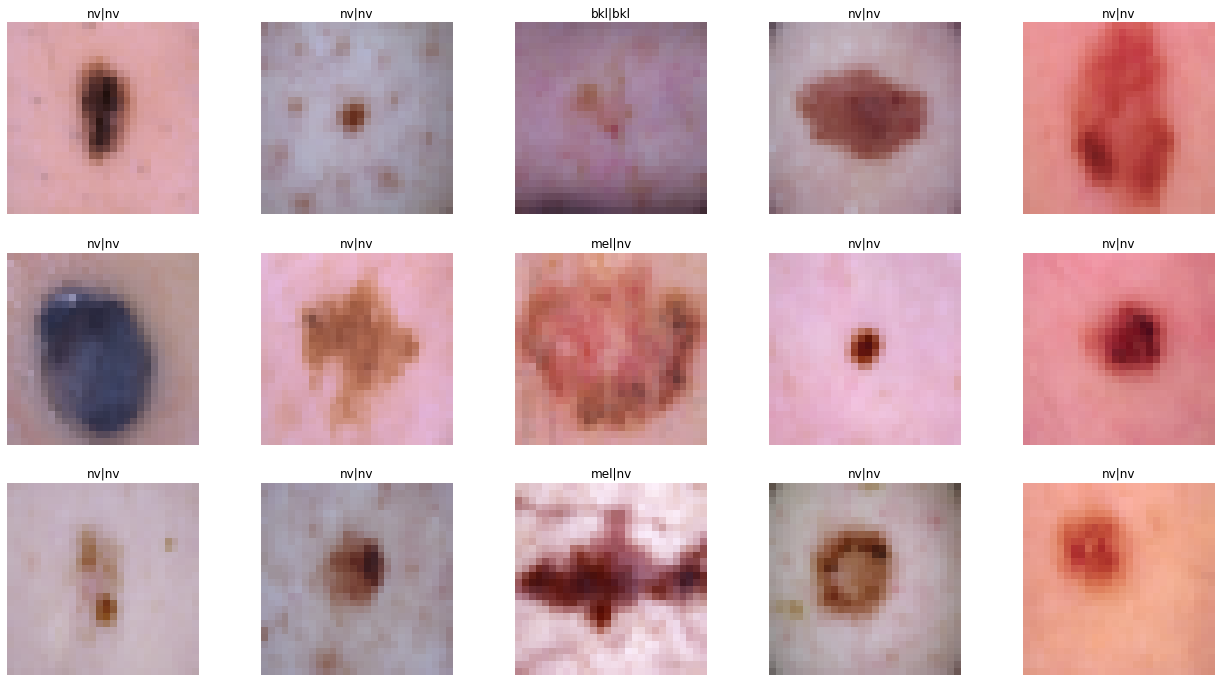

In [28]:
test_model(model1, X_test_orig, Y_test_orig)

In [29]:
# For Augmented Dataset
X_train_aug, X_test_aug, Y_train_aug, Y_test_aug = prepare_for_train_test(X_aug, Y_aug)

In [30]:
model2 = create_model()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 28, 28, 16)        448       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 14, 14, 32)        4640      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 7, 7, 64)          18496     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 4, 4, 64)          0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 4, 4, 128)        

In [31]:
model2_history = train_model(model2, X_train_aug, Y_train_aug, 50)

Epoch 1/50
458/458 [==============================] - 2s 4ms/step - loss: 3.0080 - accuracy: 0.3763 - val_loss: 0.9278 - val_accuracy: 0.6509
Epoch 2/50
458/458 [==============================] - 2s 4ms/step - loss: 0.7924 - accuracy: 0.7037 - val_loss: 0.5351 - val_accuracy: 0.8023
Epoch 3/50
458/458 [==============================] - 2s 3ms/step - loss: 0.4949 - accuracy: 0.8184 - val_loss: 0.3940 - val_accuracy: 0.8540
Epoch 4/50
458/458 [==============================] - 2s 3ms/step - loss: 0.3523 - accuracy: 0.8716 - val_loss: 0.2889 - val_accuracy: 0.8965
Epoch 5/50
458/458 [==============================] - 2s 3ms/step - loss: 0.2595 - accuracy: 0.9048 - val_loss: 0.3055 - val_accuracy: 0.8888
Epoch 6/50
458/458 [==============================] - 2s 3ms/step - loss: 0.2189 - accuracy: 0.9190 - val_loss: 0.2754 - val_accuracy: 0.8985
Epoch 7/50
458/458 [==============================] - 2s 3ms/step - loss: 0.2155 - accuracy: 0.9233 - val_loss: 0.2411 - val_accuracy: 0.9145
Epoch 

In [32]:
plot_model_training_curve(model2_history)

Test Accuracy: 97.902%
              precision    recall  f1-score   support

          nv       0.99      0.87      0.93      1385
         mel       0.94      0.99      0.96      1328
         bkl       0.95      1.00      0.97      1294
         bcc       0.99      1.00      0.99      1325
       akiec       1.00      1.00      1.00      1270
        vasc       1.00      1.00      1.00      1293
          df       1.00      1.00      1.00      1257

    accuracy                           0.98      9152
   macro avg       0.98      0.98      0.98      9152
weighted avg       0.98      0.98      0.98      9152



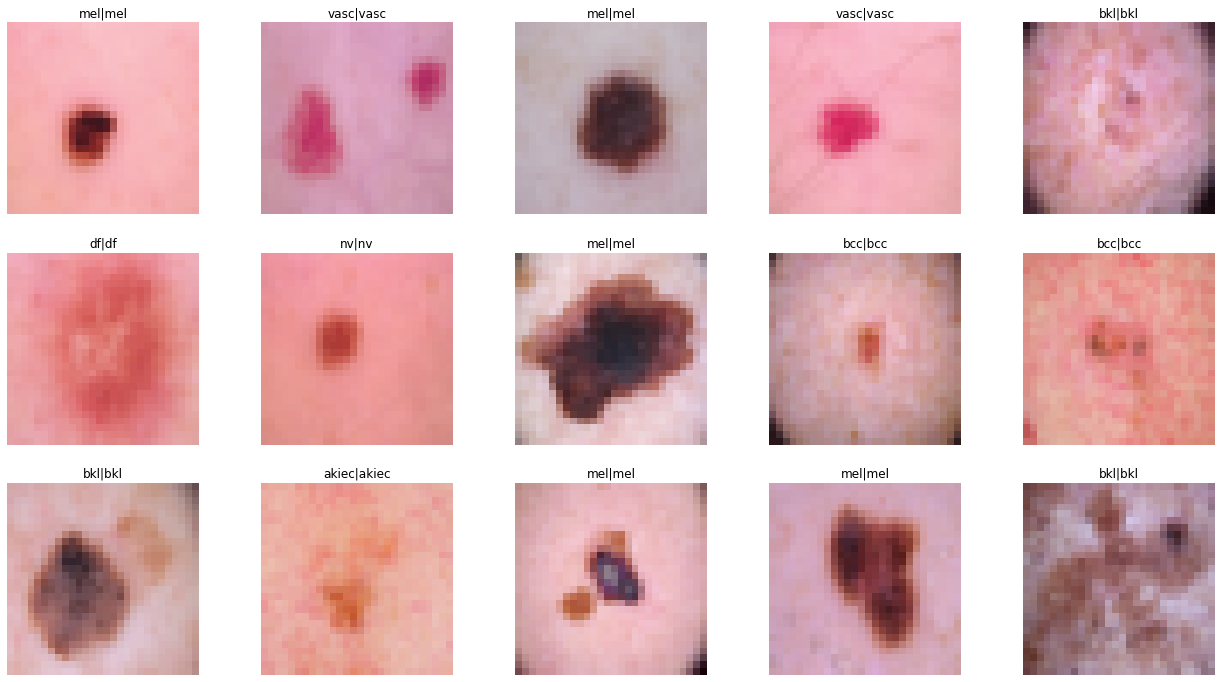

In [33]:
test_model(model2, X_test_aug, Y_test_aug)